* Desenvolva o Pipeline completo de um projeto de Aprendizado de Máquina, desde a Análise e preparação dos dados adquiridos até a disponibilização do algoritmo no GitHub.

* é disponibilizado seis (6) arquivos com extensão .npy. Sabe-se que cada arquivo foi adquirido por um sensor, os dados são oriundos de uma máquina com motor elétrico, os quais foram aquisitados a uma taxa de 10 KHz. Os dados de todos os sensores, foram adquiridos de forma simultânea, ou seja, no mesmo instante de tempo. O arquivo Classes.npy possui diferentes estados de funcionamento dessa máquina, podendo ou não possuir diferentes falhas e/ou funcionamento normal.

* Link para o drive com os dados: https://drive.google.com/drive/folders/1ztWi2pHqbbIU-wMMTydq9vssuJmWFPjS

OBS: sensores, são dispositivos capazes de medir grandezas físicas, tem seu funcionamento com base em sinais elétricos, em ambiente industrial podem captar sinais de ruídos e até mesmo entrarem em falha.

In [17]:
import glob
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy
import re
import os
import pandas as pd
import pywt
from scipy.fftpack import fft
from warnings import warn
from sklearn import metrics
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

* São 50000 samples
    * São 5 classes e o dataset está balanceado
* cada dado em sensors tem 50000 samples
    * os primeiros 3 possuem 201 valores
    * os últimos 3 possuem 200 valores 

In [2]:
n_sensors = 5
n_samples = 50000
classes = np.load('./dataset/Classes.npy', allow_pickle=True)
classes_k = ['Classe A','Classe B', 'Classe C','Classe D','Classe E']

In [3]:
print(classes.shape)
df = pd.DataFrame(data=classes, columns=["classe"])
print(df['classe'].value_counts())

(50000, 1)
Classe D    10000
Classe A    10000
Classe B    10000
Classe E    10000
Classe C    10000
Name: classe, dtype: int64


# Remoção de NaN:
* Para toda a posição onde há NaN, realiza uma interpolação do sinal e gera os valores
    * Nos sensores 0, 1, 2 e 4, parece ser um valor de vibração
        * Gerei um valor interpolado
    * no Sensor 3, o valor é sempre 50.0 em todo o dataset
        * Se foi falha de captura, esse sensor não tem qualquer informação relevante
        * Se não foi falha de captura, é melhor manter o valor
        * Na dúvida, NaN será colocado como 0 no sinal.


In [4]:
def fill_the_gaps(data):
    ok = np.invert(np.isnan(data))
    xp = ok.ravel().nonzero()[0]
    fp = data[np.invert(np.isnan(data))]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

In [5]:
sensor_data = []
for i in range(n_sensors):
    sensor_data.append(np.load(f'./dataset/Dados_{i+1}.npy', allow_pickle=True))
for i in [0,1,2,4]:
    for j in range(n_samples):
        sensor_data[i][j] = fill_the_gaps(sensor_data[i][j])

for j in range(n_samples):
    sensor_data[3][j] = np.nan_to_num(sensor_data[3][j], nan=0)

* Os ranges por classe não apresentam muita informação útil
* Por sensor, parece ser possível considerar alguns limites:
    * s0, s1 e s2: [-2.0, 5.0]
    * s3: nan ou 50.0
    * s4 -20., 140.
    
    

10 KHz
200 Samples...


In [6]:
def get_RMS(sig, f, n, w):
    steps = np.int_(np.floor(n/w))
    x_RMS = np.zeros((len(sig),steps)) #Create array for RMS valuess
    for i in range (0, steps):
        x_RMS[:,i] = np.sqrt(np.mean((sig[:, (i*w):((i+1)*w)]**2), axis=1))
    return x_RMS

In [7]:
n = np.int(200)#length of the array
freq = 10000  #sample rate (10KHz) 
time = 1/freq;
rms_global = []
peak = []
peak2peak =[]
crista = []
# rms_w50 =[]

for i in [0,1,2]:
    rms_global.append(get_RMS(sensor_data[i], freq, n, n))
    peak.append(np.max(sensor_data[i], axis=1))
    crista.append(peak[i]/rms_global[i][:,0])
    peak2peak.append(np.max(sensor_data[i], axis=1)-np.min(sensor_data[i], axis=1))
    # rms_w50.append(get_RMS(sensor_data[i], freq, n, 10))



In [8]:
for i in [0,1,2]:
    rms_global[i] = (rms_global[i]-np.min(np.min(rms_global[i])))/(np.max(np.max(rms_global[i]))-np.min(np.min(rms_global[i])))
    peak[i] = (peak[i]-np.min(np.min(peak[i])))/(np.max(np.max(peak[i]))-np.min(np.min(peak[i])))
    crista[i] = (crista[i]-np.min(np.min(crista[i])))/(np.max(np.max(crista[i]))-np.min(np.min(crista[i])))
    peak2peak[i] = (peak2peak[i]-np.min(np.min(peak2peak[i])))/(np.max(np.max(peak2peak[i]))-np.min(np.min(peak2peak[i])))

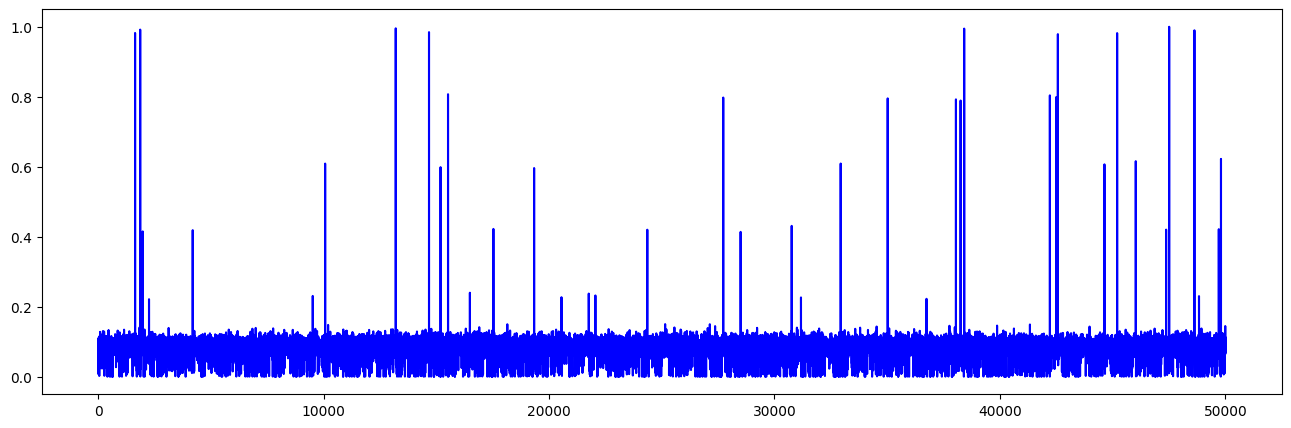

In [9]:
fig = plt.subplots(figsize=(16, 5))
plt.plot(peak2peak[0][:], color='blue')
# print(df.loc[idx]['classe'])

# Dos valores de RMS
* O RMS dos sensores 0, 1 e 2 parece conter alguma informação relevante para diferenciar algumas classes
* o RMS do sensor 4 sem window parece ser uma informação inútil
    * Será que o RMS por window contem alguma info mais interessante?

In [10]:
from scipy.fftpack import fft
def apply_fft(sig, f, n):
    xf = np.linspace(0.0, (f/2.0), n//2)
    yf = fft(sig[:])
    yf = 2.0/n * np.abs(yf[:, :n//2])
    return xf, yf

In [11]:
fft_ys = []
for i in [0,1,2, 4]:
    xfs, yfs = apply_fft(sensor_data[i], freq, n)
    max_v = np.max(np.max(yfs))
    
    fft_ys.append(yfs/max_v)
    xfs = xfs/np.max(xfs)

In [12]:
print(xfs.min())
print(np.max(np.max(fft_ys[3])))
print(np.min(np.min(fft_ys[3])))

0.0
1.0
6.41196322239529e-06


Classe B


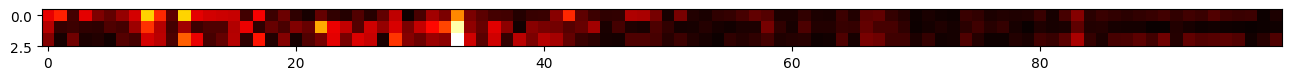

In [13]:
fig = plt.subplots(figsize=(16, 10))
idx = 6
print(df.loc[idx]['classe'])
plt.imshow([fft_ys[0][idx][:],fft_ys[1][idx][:],fft_ys[2][idx][:]], cmap='hot')

Classe D


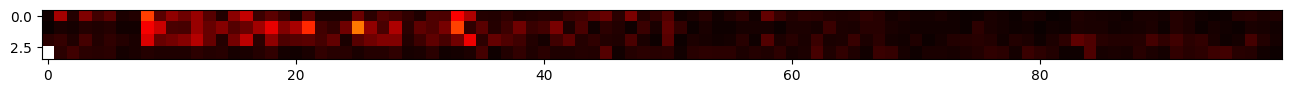

In [14]:
fig = plt.subplots(figsize=(16, 10))
idx = 10000
print(df.loc[idx]['classe'])
plt.imshow([fft_ys[0][idx][:],fft_ys[1][idx][:],fft_ys[2][idx][:],fft_ys[3][idx][:]], cmap='hot')

In [15]:
schema={'Classe': 'string'}
for s in range(3):
    schema[f's{s}_RMS'] = 'float64'
    schema[f's{s}_peak'] = 'float64'
    schema[f's{s}_peak2peak'] = 'float64'
    schema[f's{s}_crista'] = 'float64'
for s in range(3):
    for idx in range(100):
        schema[f's{s}_amp_{idx}'] = 'float64'
        
df = pd.DataFrame(columns=schema.keys()).astype(schema)

In [18]:
for idx in tqdm(range(50000)):
    f_map = {}
    f_map['Classe'] = classes[idx][0]

    for s in range(3):
        f_map[f's{s}_RMS'] = rms_global[s][idx]
        f_map[f's{s}_peak'] = peak[s][idx]
        f_map[f's{s}_peak2peak'] = peak2peak[s][idx]
        f_map[f's{s}_crista'] = crista[s][idx]

    for s in range(3):
        for i in range(100):
            f_map[f's{s}_amp_{i}'] = fft_ys[s][idx][i]
            # f_map[f's{s}_freq10_{i}'] = peak10_freq[s][idx][i]
    df.loc[len(df)] = f_map

  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
df.to_csv("./features_norm.csv", sep=',', index=False, encoding='utf-8')